### Step 1: Load the HRV Dataset




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("all_hrv_rr_metric_combined.csv")

#df.head()


In [3]:
df['Label'].unique()


array(['Pre-Meditation', 'Meditation', 'Sleeping', 'Fixed-Rate Breathing'],
      dtype=object)

In [4]:
df['Group'].unique()

array(['Chi', 'Yoga', 'Ironman', 'Metronomic', 'Normal'], dtype=object)

In [5]:
""" 
This section is a bit overkill, but it ensures that the dataset is correctly formatted 
and assigns a simplified “Condition” label (used for classification).
It transforms group-state combinations into one of:

    "Meditation"

    "Pre-Meditation"

    "Sleeping"

    "Fixed-Rate Breathing"

This allows to train models on physiological state, regardless of which group the data originally came from.

"""
# Validate essential columns
expected_columns = ["SDNN", "RMSSD", "Mean_HR", 
                    "Subject", "Group", "Label"]
# reference[18].
missing = [col for col in expected_columns 
           if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}") # no colum will be missing, however just in case

# Assign simplified Condition Labels for ML task
# this is the overkill bit.
def assign_condition(row):
    if row["Group"] in ["Chi", "Yoga"]:
        return row["Label"]  # Meditation / Pre-Meditation. this is better than writting them manually
    elif row["Group"] in ["Ironman", "Normal"]:
        return "Sleeping"
    elif row["Group"] == "Metronomic":
        return "Fixed-Rate Breathing"
    else:
        return "Unknown"

""" The gist of this code is that:

It creates a new column in the DataFrame called "Condition".

For each row, it runs the assign_condition() function.

the axis=1 tells .apply() to operate row by row (instead of column by column).

It stores the output (like "Meditation", "Sleeping", etc.) in the "Condition" column

that is:
This line maps every row in your dataset to a single, simplified condition label (e.g., Meditation, Sleeping) 
based on logic in the assign_condition() function.
It powers the ML classification by turning messy group/state combos into clear, predictable target labels.
That way I don't have to modify anything else in the future

"""
# reference[19].

df["Condition"] = df.apply(assign_condition, axis=1)





In [6]:
df["Condition"].unique()

array(['Pre-Meditation', 'Meditation', 'Sleeping', 'Fixed-Rate Breathing'],
      dtype=object)

In [7]:
"""  
This part converts string labels into numeric codes (e.g., 0, 1, 2, ...)[53].

And stores the numeric values in a new column called Condition_encoded.


"""

# Encode Condition labels[19].
label_encoder = LabelEncoder()
df["Condition_encoded"] = label_encoder.fit_transform(df["Condition"])

# Select the features and target/labels
features = ["SDNN", "RMSSD", "Mean_HR"]
target = "Condition_encoded"

X = df[features]
y = df[target]

# Split dataset into training/testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

""" 
Basically I am encoding the target labels so the model can 
understand them, selecting the features I want to use, 
and splitting the data into training and test sets to 
train and evaluate the model fairly and accurately.
"""


' \nBasically I am encoding the target labels so the model can \nunderstand them, selecting the features I want to use, \nand splitting the data into training and test sets to \ntrain and evaluate the model fairly and accurately.\n'

In [8]:
#X.head()


In [9]:
y.unique()

array([2, 1, 3, 0])

In [10]:
""" 

This code does applies standardization to features[54] (SDNN, RMSSD, Mean_HR) 
so that they all have:

    - a mean of 0

    - a standard deviation of 1

This is because KNN relies on distance calculations (e.g., Euclidean distance).

If one feature (like Mean_HR) has a larger range than others, 
it will dominate the model’s decision.
Scaling ensures all features contribute equally to the model.

"""


# Scale features [20],[21].
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# GridSearchCV for optimal K [22],[23].  
param_grid = {'n_neighbors': np.arange(1, 21)}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
gs.fit(X_train_scaled, y_train)


""" 
In the end, after trying all the options, it prints the value of k that performed the best.

This value can then be used to train the  KNN model.

"""
# reference[24].
best_k = gs.best_params_['n_neighbors']
print(f"Best k from GridSearchCV: {best_k}")


"""
In Plain English scaling ensures all features are equally important,
 then using GridSearchCV to find the best k for the 
 KNN classifier using cross-validation.
This ensures the model is tuned, 
and I am not just guessing the best parameter 

"""

Best k from GridSearchCV: 1


'\nIn Plain English scaling ensures all features are equally important,\n then using GridSearchCV to find the best k for the \n KNN classifier using cross-validation.\nThis ensures the model is tuned, \nand I am not just guessing the best parameter \n\n'

In [11]:
#print(X_train_scaled)

In [12]:
#print(X_test_scaled)

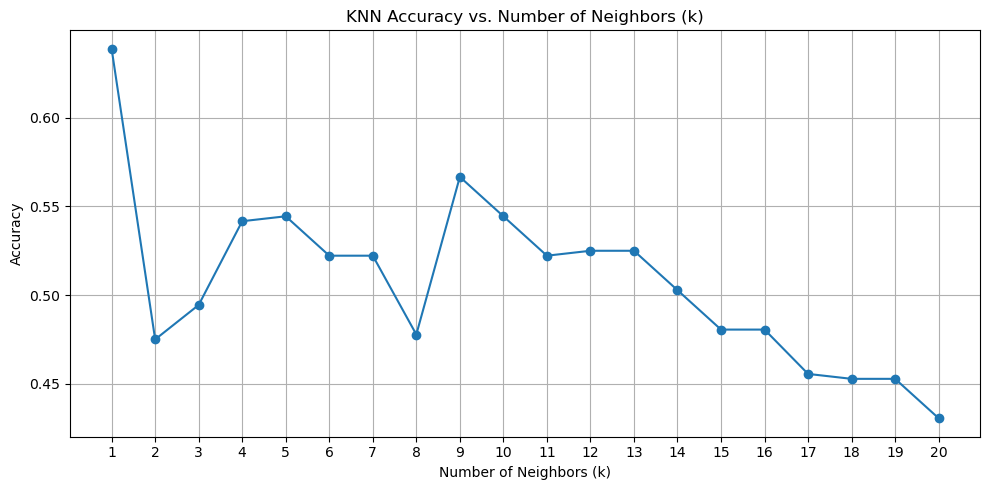

In [13]:
# Visualize the performance of each k value[25],[26].
# Extract results from GridSearchCV
k_values = param_grid['n_neighbors']
mean_scores = gs.cv_results_['mean_test_score']

# Plot the accuracy vs. number of neighbors (k)[27],[28],[29]
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_scores, marker='o')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()



In [14]:
# Train KNN with best k[30].
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)


"""
This uses the trained model to predict labels for the test set.

X_test_scaled contains features from unseen subjects.

y_pred is a list of predicted condition labels (in encoded form).

"""
# Predict and evaluate[31], [32],[33], [34].
y_pred = knn.predict(X_test_scaled)

# Performance metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)




In [15]:
# Output
print("--- BEFORE TUNING ---")
print(f"KNN Accuracy: {acc:.2f}")
print(f"KNN F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(cm)


--- BEFORE TUNING ---
KNN Accuracy: 0.50
KNN F1 Score: 0.50

Confusion Matrix:
[[2 0 0 1]
 [0 1 1 1]
 [1 0 1 0]
 [1 0 1 2]]


| **Model**             | **Accuracy** | **F1 Score** | **Precision (per class)**                             | **Recall (per class)**                                | **Support** |
|----------------------|--------------|--------------|--------------------------------------------------------|--------------------------------------------------------|-------------|
| **KNN (Before Tuning)**| 0.50         | 0.50         | FRB: 0.50, Med: 1.00, Pre: 0.33, Sleep: 0.50           | FRB: 0.67, Med: 0.33, Pre: 0.50, Sleep: 0.50           | 12          |

> **Legend**  
> - **FRB** = Fixed-Rate Breathing  
> - **Med** = Meditation  
> - **Pre** = Pre-Meditation  
> - **Sleep** = Sleeping


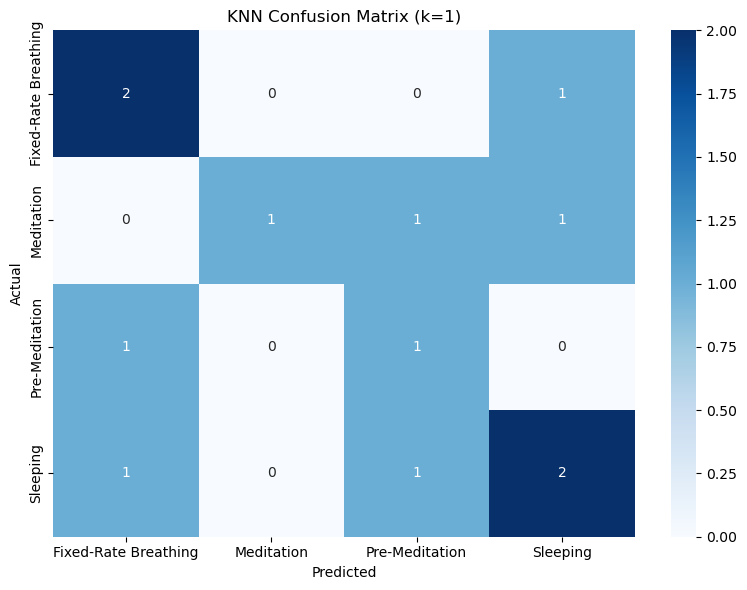

In [16]:
# Confusion Matrix Heatmap[36].
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.tight_layout()
plt.show()

In [17]:
# Tunning
# GridSearchCV for tuning[37],[38], [39].
# this could be seen as a slight overkill. Since I have already tuned the KNN model
# but this is to see if there is any difference.
param_grid_af = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_af = KNeighborsClassifier()
gs_af = GridSearchCV(knn_af, param_grid_af, cv=5, scoring='accuracy')
gs_af.fit(X_train_scaled, y_train)

best_k_af = gs_af.best_params_['n_neighbors']
print("\nBest KNN Parameters (After Tuning):", gs_af.best_params_)




Best KNN Parameters (After Tuning): {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


In [18]:
# Train KNN after tuning[55].

knn_after = KNeighborsClassifier(**gs_af.best_params_) # much cleaner
"""
The above is like doing this:

knn_after = KNeighborsClassifier(
    n_neighbors=7, 
    weights='distance', 
    metric='manhattan'
)

"""
knn_after.fit(X_train_scaled, y_train)
y_pred_after = knn_after.predict(X_test_scaled)
acc_after = accuracy_score(y_test, y_pred_after)
f1_after = f1_score(y_test, y_pred_after, average='weighted')
cm_after = confusion_matrix(y_test, y_pred_after)



In [19]:
print("\n--- AFTER TUNING ---")
print(f"KNN Accuracy: {acc_after:.2f}")
print(f"KNN F1 Score: {f1_after:.2f}")
print("Confusion Matrix:")
print(cm_after)



--- AFTER TUNING ---
KNN Accuracy: 0.50
KNN F1 Score: 0.50
Confusion Matrix:
[[2 0 0 1]
 [0 1 1 1]
 [1 0 1 0]
 [1 0 1 2]]


| **Model**             | **Accuracy** | **F1 Score** | **Precision (per class)**                             | **Recall (per class)**                                | **Support** |
|----------------------|--------------|--------------|--------------------------------------------------------|--------------------------------------------------------|-------------|
| **KNN (After Tuning)**| 0.50         | 0.50         | FRB: 0.50, Med: 1.00, Pre: 0.33, Sleep: 0.50           | FRB: 0.67, Med: 0.33, Pre: 0.50, Sleep: 0.50           | 12          |

> **Legend**  
> - **FRB** = Fixed-Rate Breathing  
> - **Med** = Meditation  
> - **Pre** = Pre-Meditation  
> - **Sleep** = Sleeping


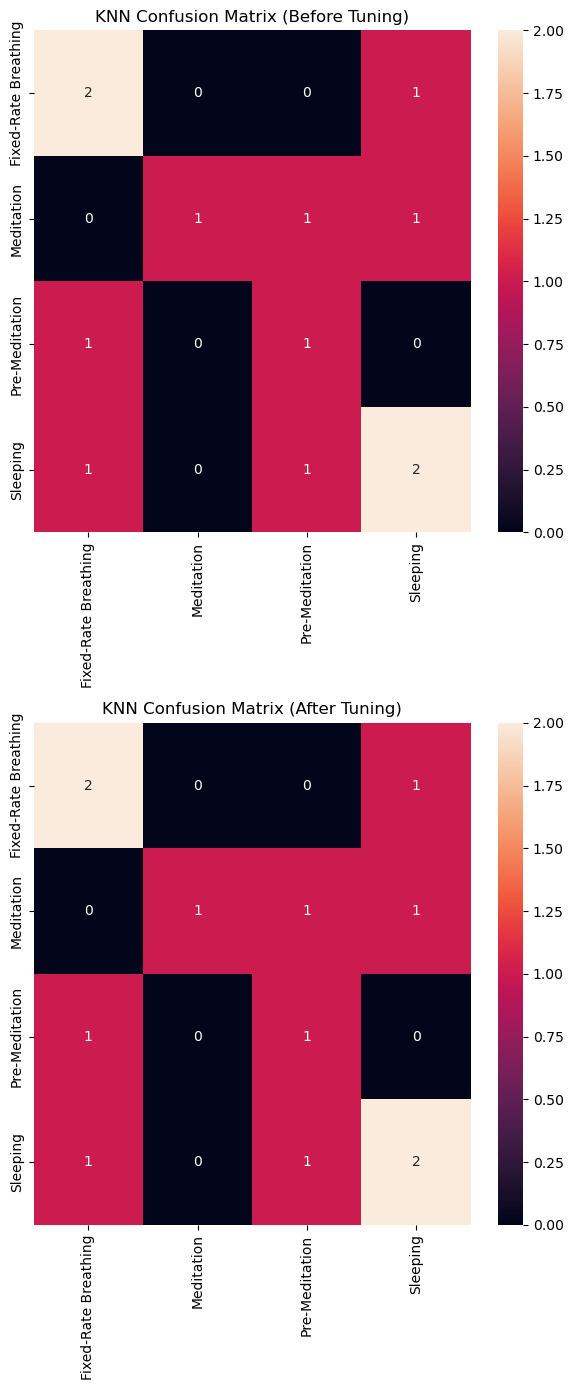

In [39]:
# Plot Confusion Matrices [40], [41].


fig, axes = plt.subplots(2 ,1 , figsize=(6 , 14))
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)


axes[0].set_title("KNN Confusion Matrix (Before Tuning)")

sns.heatmap(cm_after, annot=True, fmt='d', ax=axes[1],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1].set_title("KNN Confusion Matrix (After Tuning)")

plt.tight_layout()
plt.show()

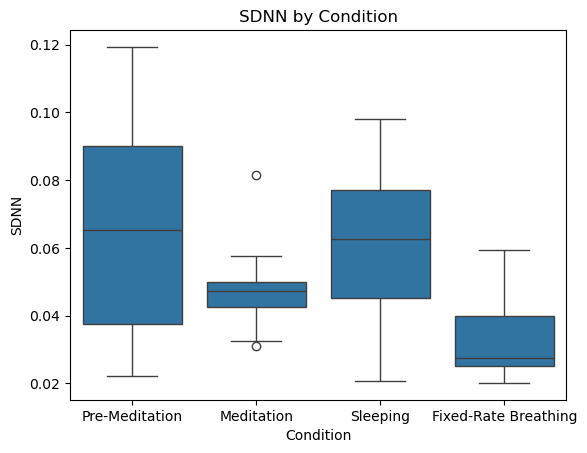

In [21]:
# refernce [42].

sns.boxplot(data=df, x="Condition", y="SDNN")
plt.title("SDNN by Condition")
plt.show()


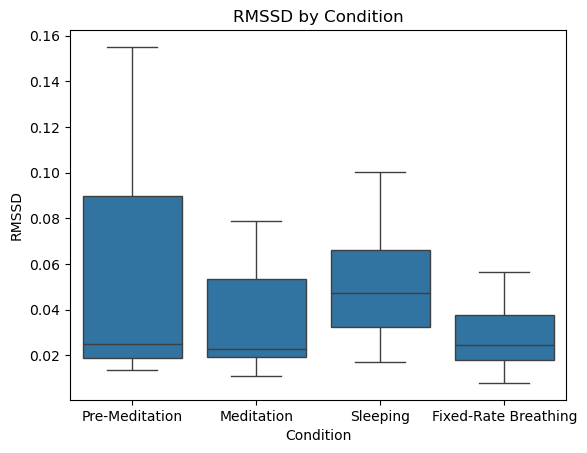

In [22]:
sns.boxplot(data=df, x="Condition", y="RMSSD")
plt.title("RMSSD by Condition")
plt.show()

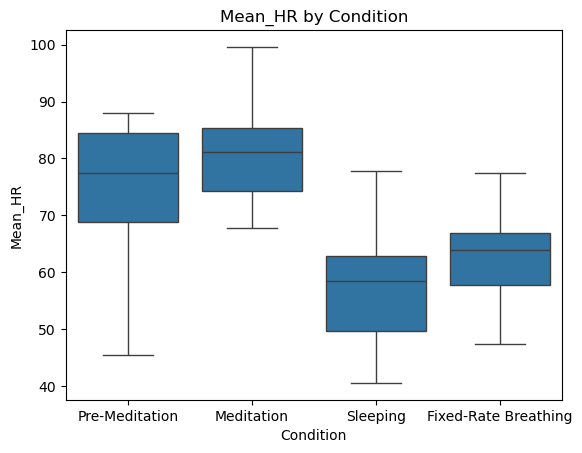

In [23]:
sns.boxplot(data=df, x="Condition", y="Mean_HR")
plt.title("Mean_HR by Condition")
plt.show()

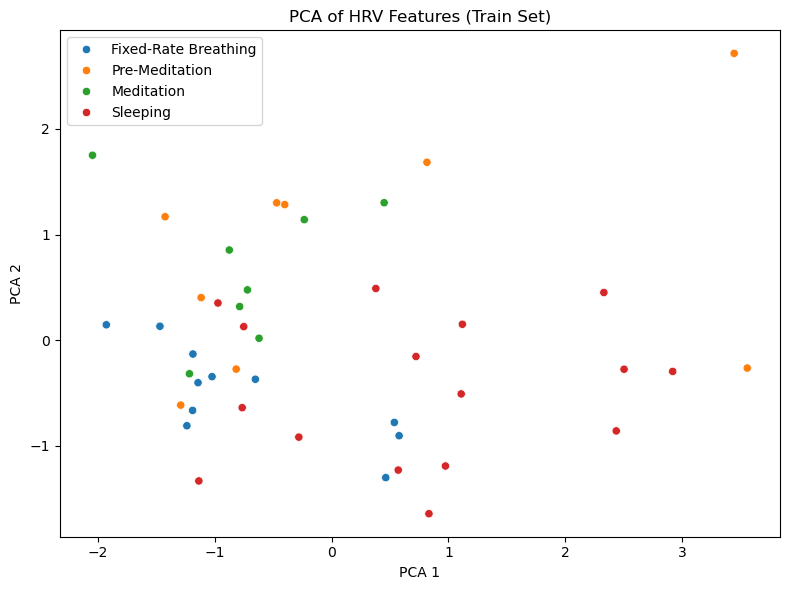

In [24]:
# PCA[43].

"""
PCA finds combinations of features[56] (called principal components) that explain the most variation in the data.

    These combinations are plotted as PCA 1, PCA 2.

    It helps visualize complex data in 2D, especially for classification tasks.

In addition:
    It helps summarize patterns across all features.

    Reduces noise or redundancy.

    Helps to see group clustering: e.g., whether Meditation is clearly separated from Sleep.

It shows that:
    Every dot is a subject.

    Colors represent the physiological condition(states) (Fixed-Rate Breathing, Meditation, etc.).

    If the colors cluster, it means PCA successfully captured distinct patterns in HRV data by condition.

    If they overlap, conditions might be more similar .


""" 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))

# reference [43].
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label_encoder.inverse_transform(y_train))
plt.title("PCA of HRV Features (Train Set)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()


### Step 3: Train Random Forest Model

In [25]:
# Train RandomForest Classifier [44],[45].

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)  
"""
RandomForest does not need
scaling, but at the same time, I would like to avoid
re-writing any unecessary code, and since scalling,
won't harm performance nor improve it.
I have decided to leave it be
"""
# Predict and evaluate
y_pred_rf  = rf.predict(X_test_scaled)

acc_rf  = accuracy_score(y_test, y_pred_rf )
f1_rf  = f1_score(y_test, y_pred_rf , average='weighted')
cm_rf  = confusion_matrix(y_test, y_pred_rf )



In [26]:
print(f"Random Forest Accuracy: {acc_rf :.2f}")
print(f"Random Forest F1 Score: {f1_rf :.2f}")
print("\nConfusion Matrix:")
print(cm_rf )


Random Forest Accuracy: 0.58
Random Forest F1 Score: 0.59

Confusion Matrix:
[[2 0 0 1]
 [0 2 1 0]
 [0 1 1 0]
 [1 0 1 2]]


| **Model**             | **Accuracy** | **F1 Score** | **Precision (per class)**                             | **Recall (per class)**                                | **Support** |
|----------------------|--------------|--------------|--------------------------------------------------------|--------------------------------------------------------|-------------|
| **Random Forest**     | 0.58         | 0.59         | FRB: 0.67, Med: 0.67, Pre: 0.33, Sleep: 0.67           | FRB: 0.67, Med: 0.67, Pre: 0.50, Sleep: 0.50           | 12          |

> **Legend**  
> - **FRB** = Fixed-Rate Breathing  
> - **Med** = Meditation  
> - **Pre** = Pre-Meditation  
> - **Sleep** = Sleeping


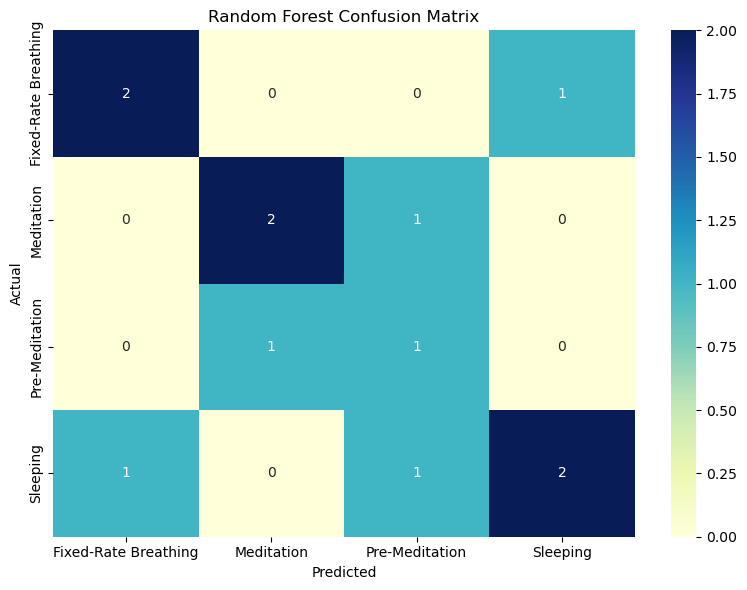

In [27]:
# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf , annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [28]:
# Feature importance visualization[46],[47], [48]

"""
In the context of Random Forest classifier[57], 
    feature importance tells how useful each feature (input variable) is 
    when it comes to predicting the target class 

In plain Epenglish:
    A higher importance score means the model relied more heavily on that feature when making decisions.
    A lower importance score means the feature contributed less to the model's predictions.


"""

importances = rf.feature_importances_
feature_names = features

plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [29]:
# Parameter Tunning[61],[62].
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
# reference[49].

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf,
                       cv=5,
                       scoring='accuracy')
rf_grid.fit(X_train_scaled, y_train)

print("\nBest Parameters (After Tuning):", rf_grid.best_params_)

# Train and Evaluate Tuned Model
rf_tuned = rf_grid.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average='weighted')
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)




Best Parameters (After Tuning): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [30]:
print("\nRandom Forest (After Tuning):")
print(f"Accuracy after tunning: {acc_rf_tuned:.2f}")
print(f"F1 Score after tunning: {f1_rf_tuned:.2f}")
print("Confusion Matrix after tunning:")
print(cm_rf_tuned)


Random Forest (After Tuning):
Accuracy after tunning: 0.58
F1 Score after tunning: 0.59
Confusion Matrix after tunning:
[[2 0 0 1]
 [0 2 1 0]
 [0 1 1 0]
 [1 0 1 2]]


## Comparison between KNN and RandomForest

In [31]:
# Accuracy & F1 Score
print("KNN Accuracy:", acc )
print("RF Accuracy:", acc_rf)

print("KNN F1 Score:", f1)
print("RF F1 Score:", f1_rf)


KNN Accuracy: 0.5
RF Accuracy: 0.5833333333333334
KNN F1 Score: 0.5011904761904762
RF F1 Score: 0.5904761904761905


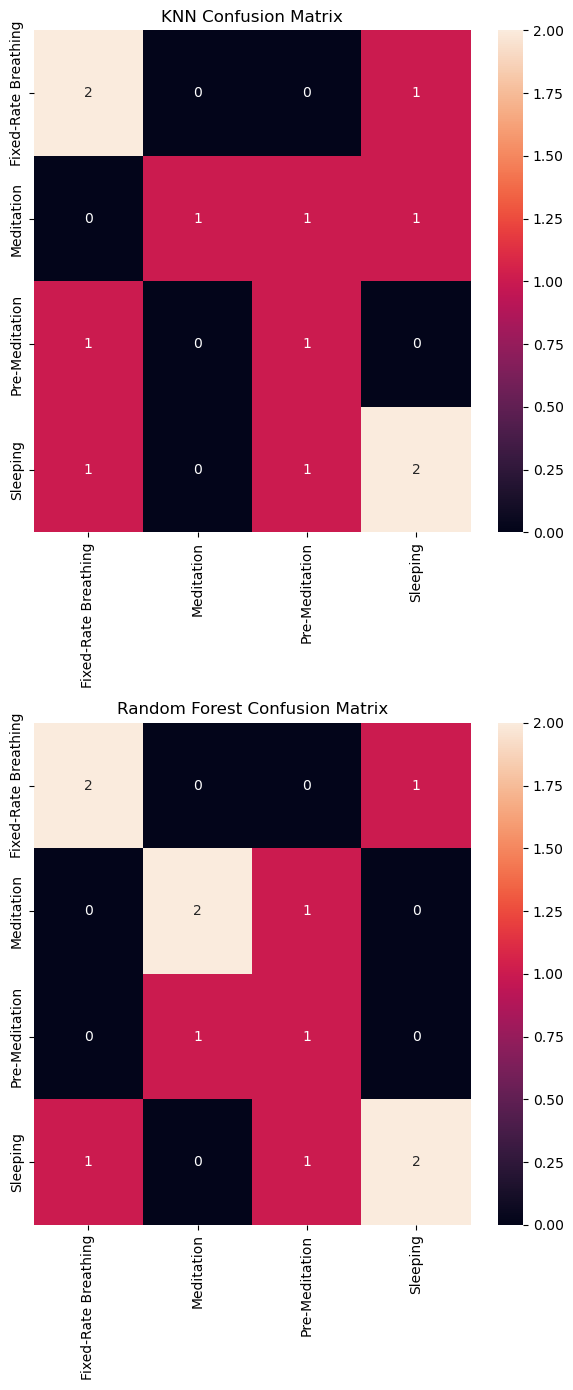

In [40]:
# Confusion Matrix Side-by-Side:
fig, axes = plt.subplots(2, 1, figsize=(6, 14))

sns.heatmap(cm, annot=True, fmt='d', ax=axes[0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[0].set_title("KNN Confusion Matrix")

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1].set_title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()



In [33]:
# Print a Side-by-Side Report
print(f"{'Model':<15}{'Accuracy':<10}{'F1 Score':<10}")
print(f"{'-'*35}")
print(f"{'KNN':<15}{acc:.2f}{f1:.2f}")
print(f"{'Random Forest':<15}{acc_rf:.2f}{f1_rf:.2f}")


Model          Accuracy  F1 Score  
-----------------------------------
KNN            0.500.50
Random Forest  0.580.59


In [34]:

# --- Logistic Regression ---
"""
Logistic Regression is a supervised machine learning algorithm used to[58]:

    Predict categories (labels) based on input features — for instance multi-class features (like your meditation states: Meditation, Sleep, etc.).

Basically:
    It looks at the relationship between features (e.g., RMSSD, SDNN, Mean_HR) and a probability of each class.
    Then it uses a logistic function to squeeze those probabilities into values between 0 and 1.

It picks the class with the highest predicted probability.



"""
# reference [50]. 

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log, average='weighted')
cm_log = confusion_matrix(y_test, y_pred_log)



In [35]:
# --- Support Vector Machine (SVM) ---
"""
Support Vector Machine (SVM)[59] is a supervised learning algorithm used for:

    Classifying data by finding the best boundary (hyperplane) that separates different classes.


SVM tries to find the line (or plane) that best separates the classes of data, 
while maximizing the margin between them.

The margin is 
    the distance between the boundary and the closest data points from each class (called support vectors).
    SVM wants this margin to be as wide as possible to improve generalization.

Plainly:
    it plots the data in high-dimensional space (e.g., 2D, 3D… or more).
    Finds the optimal hyperplane that separates the classes.
    Uses only the most critical data points (support vectors) to define this boundary.

"""


# reference[51].

svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
cm_svm = confusion_matrix(y_test, y_pred_svm)



In [36]:
# --- Gradient Boosting Classifier ---

"""
Gradient Boosting Classifier[60] is a ensemble learning model that:
    combine multiple  weak learners (usually decision trees)
    into one strong model
    by learning from its own mistakes step-by-step



"""

# reference [52] 

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train_scaled, y_train)
y_pred_gbc = gbc.predict(X_test_scaled)
acc_gbc = accuracy_score(y_test, y_pred_gbc)
f1_gbc = f1_score(y_test, y_pred_gbc, average='weighted')
cm_gbc = confusion_matrix(y_test, y_pred_gbc)



In [37]:
# --- Print Metrics ---
print("\n--- Logistic Regression ---")
print(f"Accuracy: {acc_log:.2f}, F1 Score: {f1_log:.2f}")

print("\n--- SVM ---")
print(f"Accuracy: {acc_svm:.2f}, F1 Score: {f1_svm:.2f}")

print("\n--- Gradient Boosting ---")
print(f"Accuracy: {acc_gbc:.2f}, F1 Score: {f1_gbc:.2f}")





--- Logistic Regression ---
Accuracy: 0.67, F1 Score: 0.67

--- SVM ---
Accuracy: 0.67, F1 Score: 0.68

--- Gradient Boosting ---
Accuracy: 0.50, F1 Score: 0.49


### Model performance summary

| **Model**             | **Accuracy** | **F1 Score** | **Precision (per class)**                             | **Recall (per class)**                                | **Support** |
|----------------------|--------------|--------------|--------------------------------------------------------|--------------------------------------------------------|-------------|
| **Logistic Regression** | 0.67         | 0.67         | FRB: 0.75, Med: 0.67, Pre: 0.33, Sleep: 1.00           | FRB: 1.00, Med: 0.67, Pre: 0.50, Sleep: 0.50           | 12          |
| **SVM**              | 0.67         | 0.68         | FRB: 0.60, Med: 1.00, Pre: 0.33, Sleep: 1.00           | FRB: 1.00, Med: 0.67, Pre: 0.50, Sleep: 0.50           | 12          |
| **Gradient Boosting**| 0.50         | 0.49         | FRB: 0.33, Med: 1.00, Pre: 0.00, Sleep: 0.50           | FRB: 0.33, Med: 0.33, Pre: 0.00, Sleep: 0.50           | 12          |

> **Legend**  
> - **FRB** = Fixed-Rate Breathing  
> - **Med** = Meditation  
> - **Pre** = Pre-Meditation  
> - **Sleep** = Sleeping


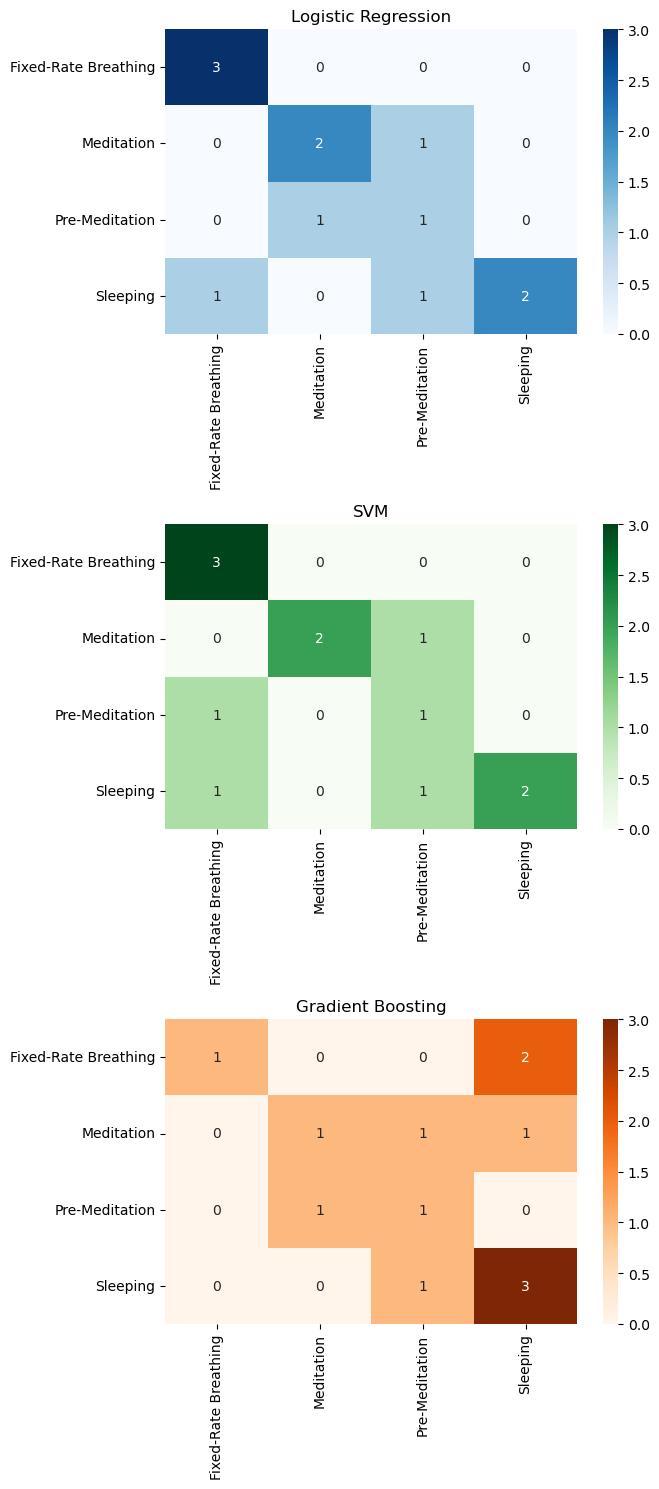

In [38]:
# --- Visual Comparison ---
fig, axes = plt.subplots(3, 1, figsize=(7, 15))
sns.heatmap(cm_log, annot=True, fmt='d', ax=axes[0], cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title("Logistic Regression")

sns.heatmap(cm_svm, annot=True, fmt='d', ax=axes[1], cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title("SVM")

sns.heatmap(cm_gbc, annot=True, fmt='d', ax=axes[2], cmap='Oranges',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[2].set_title("Gradient Boosting")

plt.tight_layout()
plt.show()